## Modules à importer

In [1]:
import math
import scipy
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from sklearn.cluster import KMeans
from variaIa.variaIa import baserate
from variaIa.variaIa import stretchevol
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

In [2]:
d = pd.read_csv('../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SDSS', 'SNLS', 'PS1', 'HST', 'SNF']

su = ipw.Dropdown(options=surveys,
                  description='Survey:',
                  value = 'SNLS')

surv = {'SDSS': d[d['IDSURVEY'] == 1],
        'SNLS': d[d['IDSURVEY'] == 4],
        'PS1':  d[d['IDSURVEY'] == 15],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])],
        'SNF':  d_snf}

# .loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)]

colors = {'SDSS': 'lime',
          'SNLS': 'red',
          'PS1': 'blue',
          'HST': 'purple',
          'SNF': 'orange'}

zmax = {'SDSS': 0.22,
        'SNLS': 0.70,
        'PS1': 0.33,
        'HST': 10,
        'SNF': 10}

def set_data(su):
    global ns_dataz, dataz, ns_datax, datax
    if su == 'SNF':
        ns_dataz = surv[su]['host.zcmb'].values
        dataz = np.sort(ns_dataz)
        ns_datax = surv[su]['salt2.X1'].values
        datax = np.sort(ns_datax)
    else:
        ns_dataz = surv[su].zCMB.values
        dataz = np.sort(ns_dataz)
        ns_datax = surv[su].x1.values
        datax = np.sort(ns_datax)
    
int_data = ipw.interactive(set_data, su = su)
display(int_data)

interactive(children=(Dropdown(description='Survey:', index=1, options=('SDSS', 'SNLS', 'PS1', 'HST', 'SNF'), …

## Choix des bins pour les listes de redshifts et de stretch

In [7]:
nb_z = ipw.IntSlider(min = 3, max = 30, value = 12, description='#bins for z:', continuous_update=False)

def set_bins_z(nb_z):
    global binsz, bordz, countsz
    bordz = np.asarray(np.histogram(dataz, bins = nb_z)[1])
    binsz = np.asarray([[bordz[i],bordz[i+1]] for i in range(len(bordz)-1)]).T
    countsz = np.histogram(dataz, bordz)[0]
    
int_bins_z = ipw.interactive(set_bins_z, nb_z = nb_z)
display(int_bins_z)

nb_x = ipw.IntSlider(min = 3, max = 30, value = 12, description='#bins for x:', continuous_update=False)

def set_bins_x(nb_x):
    global binsx, bordx, countsx
    bordx = np.asarray(np.histogram(datax, bins = nb_x)[1])
    binsx = np.asarray([[bordx[i],bordx[i+1]] for i in range(len(bordx)-1)]).T
    countsx = np.histogram(datax, bordx)[0]
    
int_bins_x = ipw.interactive(set_bins_x, nb_x = nb_x)
display(int_bins_x)

interactive(children=(IntSlider(value=12, continuous_update=False, description='#bins for z:', max=30, min=3),…

interactive(children=(IntSlider(value=12, continuous_update=False, description='#bins for x:', max=30, min=3),…

## Tracé des redshifts de l'échantill choisi

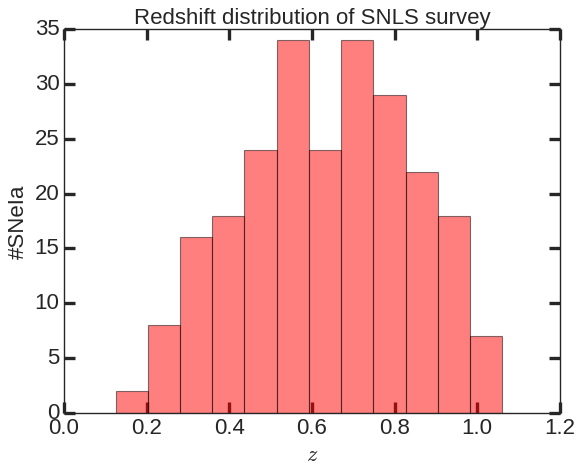

In [8]:
#plt.style.use('dark_background')
plt.style.use(['classic', 'seaborn-white'])

plt.hist(np.sort(ns_dataz), bins = nb_z.value, color = colors[su.value], alpha = .5)

ax = plt.gca()
ax.tick_params(axis = 'both',
               direction = 'in',
               length = 10, width = 3,
               labelsize = 20,
               which = 'both',
               top = True, right = True)
plt.xlabel('$z$', fontsize = 20)
plt.ylabel('#SNeIa', fontsize = 20)

plt.title('Redshift distribution of ' + str(su.value) + ' survey', fontsize = 20)

plt.show()

## Définitions des dictionnaires : $z[:z_{\text{max}}]$, $x_1[:z_{\text{max}}]$, mean et std

In [5]:
zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()
x1_err_zcuts = dict()

for survey in surveys[:-1]:
    zmax_cuts[survey] = np.where(surv[survey].zCMB.values < zmax[survey])
    z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
    x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
    x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    
zmax_cuts['SNF'] = np.where(surv['SNF']['host.zcmb'].values < zmax['SNF'])
z_zcuts['SNF'] = surv['SNF']['host.zcmb'].values[zmax_cuts['SNF']]
x1_zcuts['SNF'] = surv['SNF']['salt2.X1'].values[zmax_cuts['SNF']]
x1_err_zcuts['SNF'] = surv['SNF']['salt2.X1.err'].values[zmax_cuts['SNF']]

z_mean = dict()
z_std = dict()
x1_mean = dict()
x1_std = dict()

for survey in surveys:
    z_mean[survey] = np.mean(z_zcuts[survey])
    z_std[survey] = np.std(z_zcuts[survey])
    x1_mean[survey] = np.mean(x1_zcuts[survey])
    x1_std[survey] = np.std(x1_zcuts[survey])

## Tracé du stretch de l'échantillon choisi, coupé à zmax

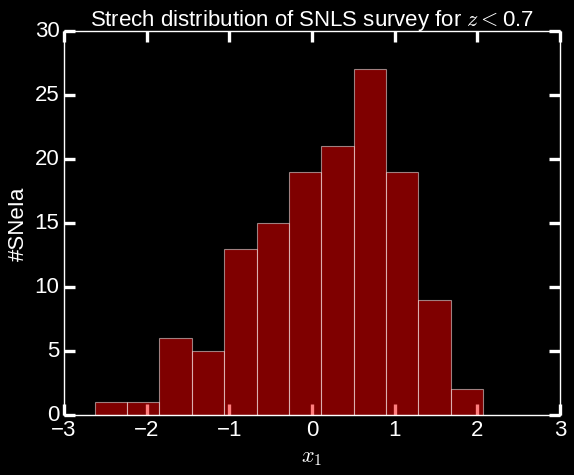

In [9]:
plt.style.use('dark_background')
#plt.style.use('seaborn-white')

cut = np.where(ns_dataz<zmax[su.value])

plt.hist(np.sort(ns_datax[cut]), bins = nb_x.value, color = colors[su.value], alpha = .5)

ax = plt.gca()
ax.tick_params(axis = 'both',
               direction = 'in',
               length = 10, width = 3,
               labelsize = 20,
               which = 'both',
               top = True, right = True)
plt.xlabel('$x_1$', fontsize = 20)
plt.ylabel('#SNeIa', fontsize = 20)

plt.title('Strech distribution of ' + str(su.value) + ' survey for $z < $' +
           str(zmax[su.value]), fontsize = 20)

plt.show()

## Tracé des stretchs cut à $z_{\text{max}}$

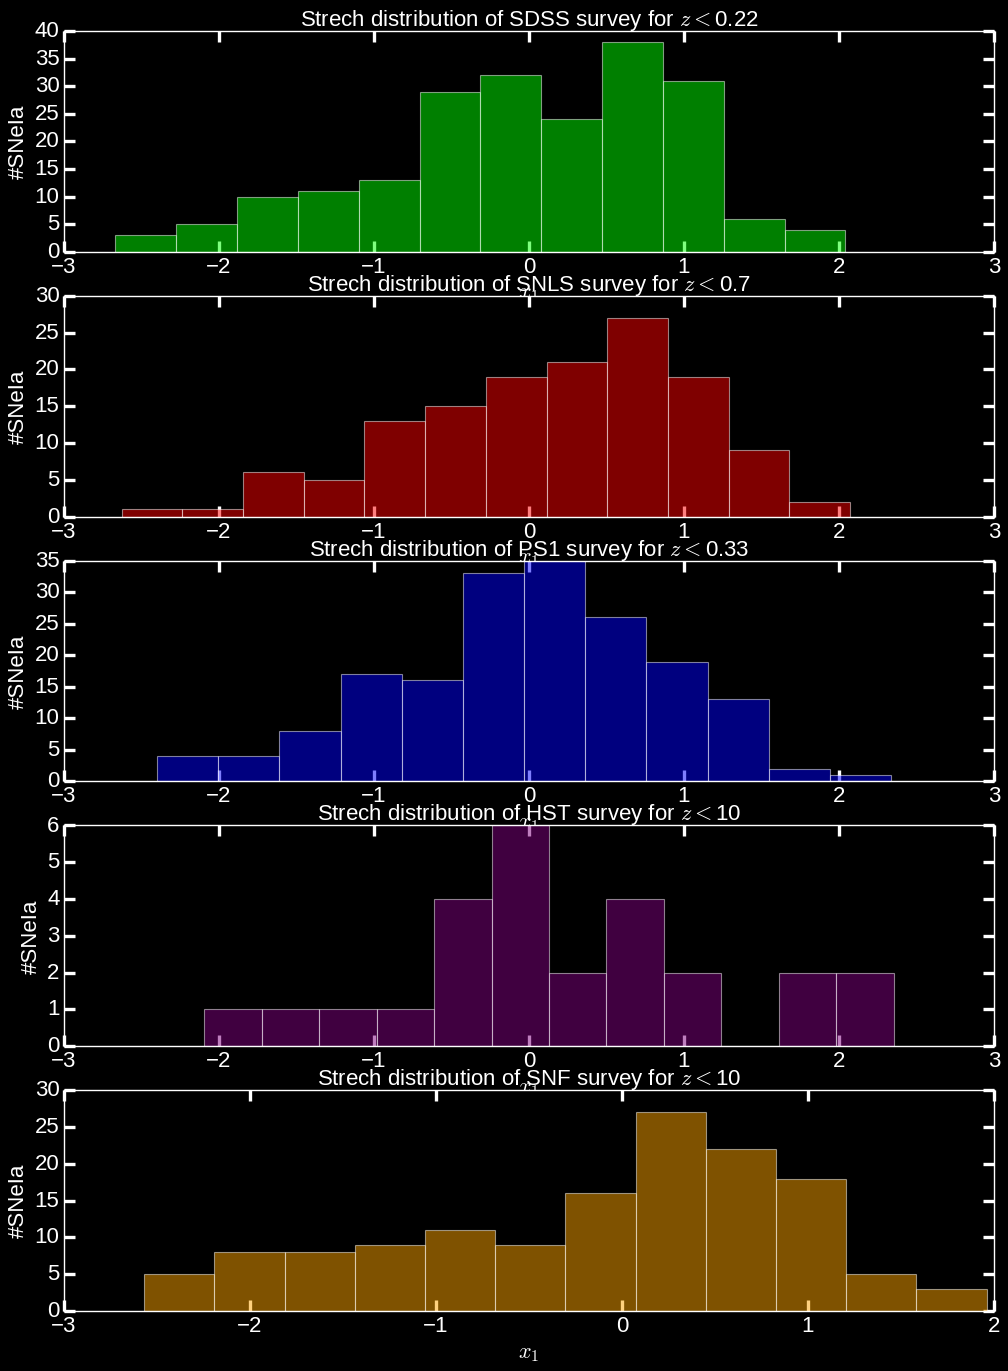

In [10]:
plt.style.use('dark_background')
#plt.style.use('seaborn-white')

plt.figure(figsize = [15,20])

for i in range(len(surveys)):
    plt.subplot(5, 1, i+1)
    plt.hist(x1_zcuts[surveys[i]], bins = nb_x.value, color = colors[surveys[i]], alpha = .5)

    ax = plt.gca()
    ax.tick_params(axis = 'both',
                   direction = 'in',
                   length = 10, width = 3,
                   labelsize = 20,
                   which = 'both',
                   top = True, right = True)
    plt.xlabel('$x_1$', fontsize = 20)
    plt.ylabel('#SNeIa', fontsize = 20)

    plt.title('Strech distribution of ' + surveys[i] + ' survey for $z < $' +
              str(list(zmax.values())[i]), fontsize = 20)

plt.show()

## Définition des dictionnaires généraux : $x_1 < -0.5$ cuts

In [6]:
xmax_cuts = dict()
x1_xcuts = dict()
z_xcuts = dict()

for survey in surveys:
    xmax_cuts[survey] = np.where(x1_zcuts[survey] < -.5)
    x1_xcuts[survey] = x1_zcuts[survey][xmax_cuts[survey]]
    z_xcuts[survey] = z_zcuts[survey][xmax_cuts[survey]]

## Tracé de la fraction de SNe de $x_1 < -0.5$ en fonction de $z_{\text{mean}}$

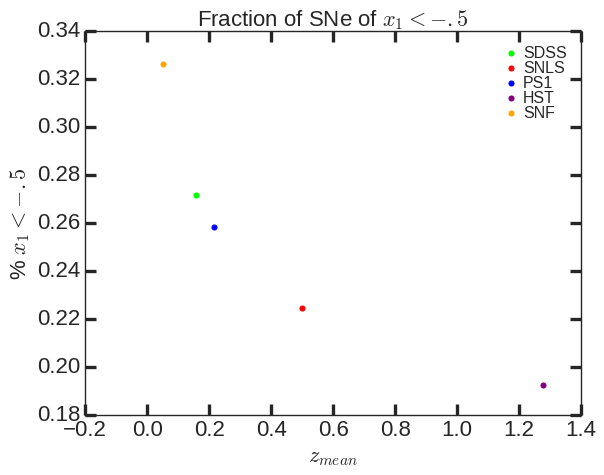

In [8]:
#plt.style.use('dark_background')
plt.style.use(['classic', 'seaborn-white'])

for i in range(5):
    plt.scatter(z_mean[surveys[i]], len(x1_xcuts[surveys[i]])/len(x1_zcuts[surveys[i]]),
                color = colors[surveys[i]], label = surveys[i])
    
ax = plt.gca()
ax.tick_params(axis = 'both',
               direction = 'in',
               length = 10, width = 3,
               labelsize = 20,
               which = 'both',
               top = True, right = True)
plt.xlabel('$z_{mean}$', fontsize = 20)
plt.ylabel('% $x_1 < -.5$', fontsize = 20)

plt.legend(ncol=1, loc='upper right', 
           #bbox_to_anchor=[0.5, 1.1], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=True)

plt.title('Fraction of SNe of $x_1 < -.5$', fontsize = 20)

plt.show()